In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 23 09:34:29 2019

@author: hurenjie
"""
#%%
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import talib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn import tree
import graphviz 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings

In [ ]:
seed = 42
#%%
warnings.filterwarnings('ignore')
data_path = '/Users/hurenjie/Desktop/同梁志能/Code/机器学习'

df = pd.read_csv(data_path + '/IF000_5分钟_长数据.csv', 
                 header = None, 
                 names = ['date','open', 'high', 'low', 'close', 'volume', 'open interest'],
                 parse_dates = True,
                 index_col = 0)
ave = df['close'].rolling(22).mean()
bias = (df['close']-ave)/ave
df['bias'] = bias

df['atr'] = talib.ATR(df.high,df.low,df.close, timeperiod=22)

df_close_diff = df['close'].diff()
movement = [1 if i>0 else 0 for i in df_close_diff]
df['movement'] = movement

df = df[['close', 'volume', 'open interest', 'movement','bias', 'atr']]
df['close'] = df['close'].shift(-1)
df['movement'] = df['movement'].shift(-1)
#%%
df['ma5'] = df['close'].rolling(5).apply(np.mean)
df['ma20'] = df['close'].rolling(20).apply(np.mean)
#df['ma60'] = df['close'].rolling(60).apply(np.mean)
#df['ma120'] = df['close'].rolling(120).apply(np.mean)
#df['ma240'] = df['close'].rolling(240).apply(np.mean)

df['ema5'] = df['close'].ewm(span=30, min_periods = 5).mean()
df['ema20'] = df['close'].ewm(span=30, min_periods = 20).mean()
#df['ema60'] = df['close'].ewm(span=30, min_periods = 60).mean()
#df['ema120'] = df['close'].ewm(span=30, min_periods = 120).mean()
#df['ema240'] = df['close'].ewm(span=30, min_periods = 240).mean()

macd, macdsignal, macdhist = talib.MACD(df['close'], 
                                fastperiod=12, 
                                slowperiod=26, 
                                signalperiod=9)
df['macd'] = macd


df = df.dropna(how = 'any')

# 初始数据 

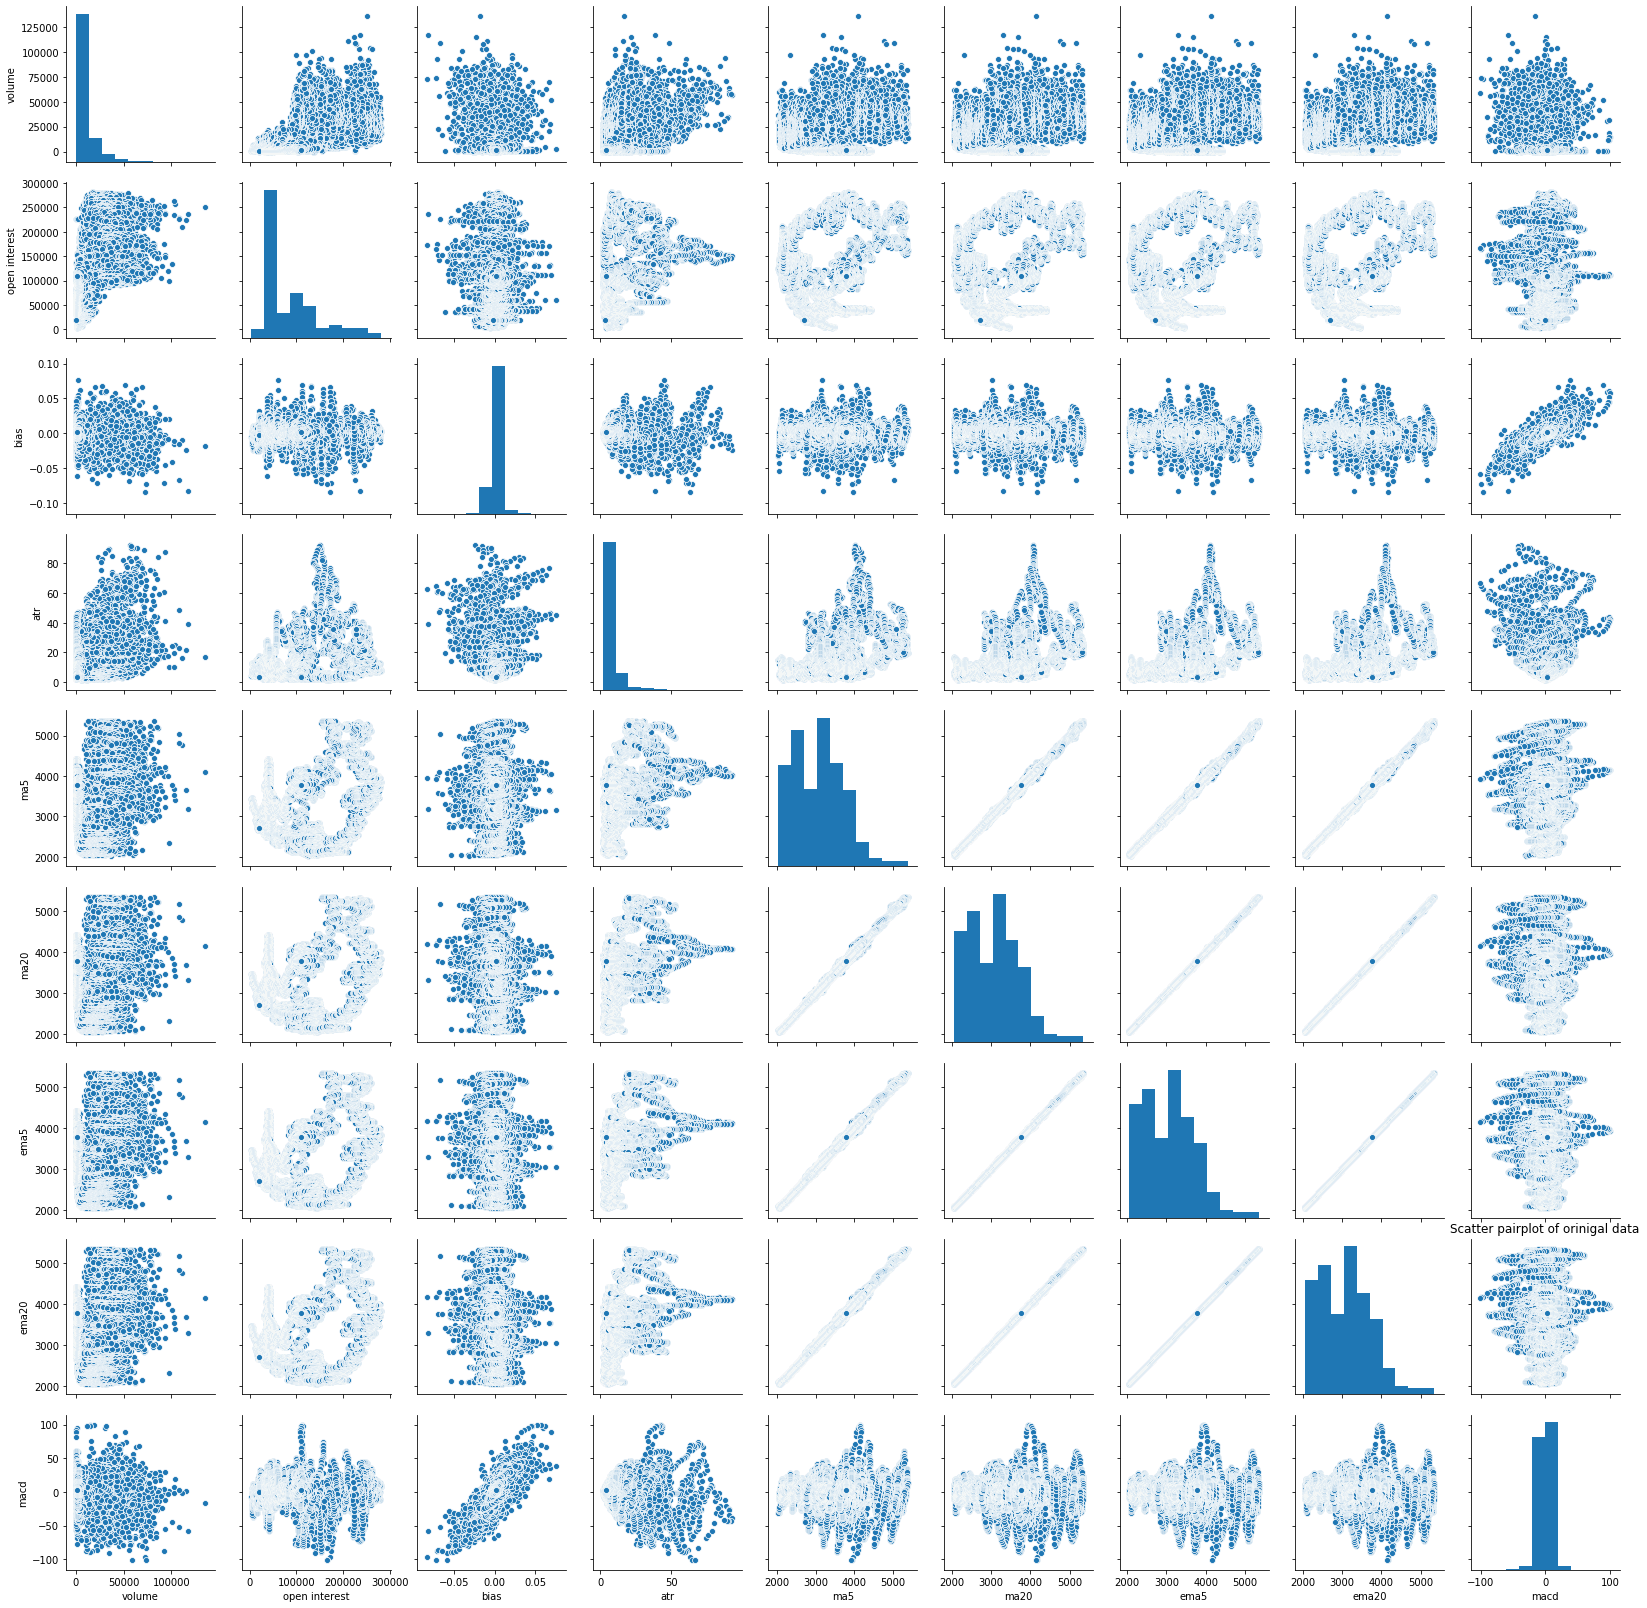

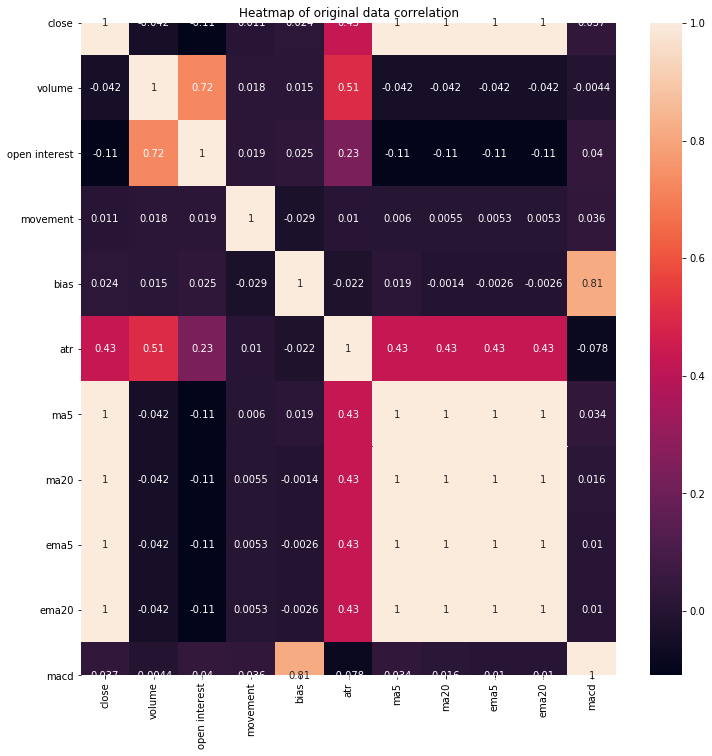

In [35]:
#%%
X = df.columns.tolist()
X.remove('close')
X.remove('movement')

X = df[X]
y = df[['close', 'movement']]

sns.pairplot(data = X)
plt.title('Scatter pairplot of orinigal data')
plt.show()

plt.figure(figsize = (12,12))
sns.heatmap(data = df.corr(), annot = True)
plt.title('Heatmap of original data correlation')
plt.show()
 

# 数据预处理

In [47]:
#%%data preprocessing
X_train, X_test, y_train, y_test = train_test_split (X, y['close'], 
                                                     test_size = 0.2, 
                                                     random_state=seed)

In [49]:
# standardizatze the data
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X))
X_std.columns = X.columns
X_std.index = X.index
X_train_std = pd.DataFrame(scaler.fit_transform(X_train))
X_train_std.columns = X_train.columns
X_train_std.index = X_train.index
X_test_std = pd.DataFrame(scaler.fit_transform(X_test))
X_test_std.columns = X_test.columns
X_test_std.index = X_test.index


#sns.pairplot(X_std)
#plt.title('Scatter pairplot of standardized data')
#plt.show()

#plt.figure(figsize = (12,12))
#sns.heatmap(pd.concat([y['close'], X_std], axis = 1).corr(), annot = True)
#plt.title('Heatmap of standardized data correlationn')

#%% 

# 线性拟合

## 线性回归

线性回归模型平均分数为:
0.9999990672587898


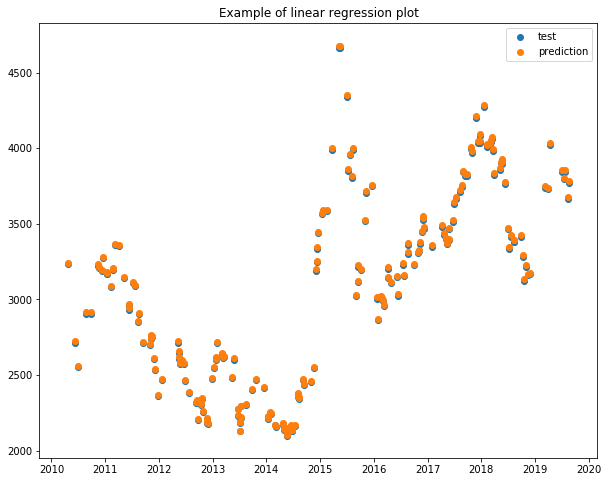

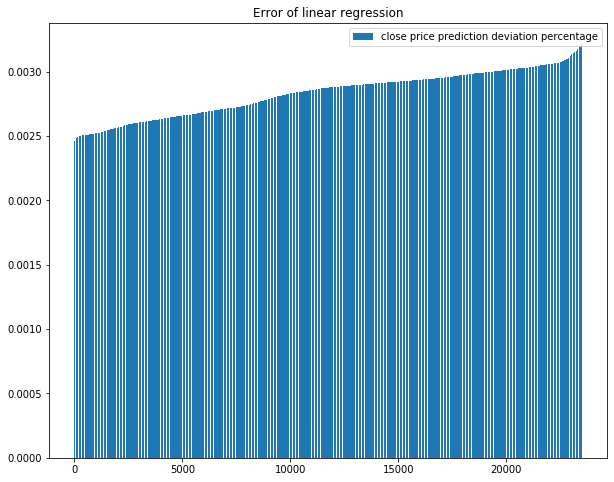

线性回归后拟合数据偏离度最大值:
0.0032192642594269217
线性回归后拟合数据偏离度最小值:
0.0024543581215266605


In [51]:
#%% Linear models
# Linear regression
lr = LinearRegression()
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)
y_pred = pd.Series(y_pred, index = y_test.index)

lr_cv_results = cross_val_score(lr, X_std, y, cv = 10)
lr_best_score = max(lr_cv_results)

print('线性回归模型平均分数为:\n{}'.format(np.mean(lr_best_score)))

plt.figure(figsize = (10,8))
plt.scatter(y_test.index[-200:], y_test.iloc[-200:], label = 'test')
plt.scatter(y_pred.index[-200:], y_pred.iloc[-200:], label = 'prediction')
plt.title("Example of linear regression plot")
plt.legend(loc = 'upper right')
plt.show()

plt.figure(figsize = (10,8))
plt.bar(x= range(1,len(y_test)+1), height = sorted((y_pred-y_test)/y_test))
plt.legend(['close price prediction deviation percentage'], loc = 'upper right')
plt.title('Error of linear regression')
plt.show()
print('线性回归后拟合数据偏离度最大值:\n{}'.format(max(np.abs((y_pred - y_test)/y_test))))
print('线性回归后拟合数据偏离度最小值:\n{}'.format(min(np.abs((y_pred - y_test)/y_test))))

## Ridge

最好的ridge参数为:
{'alpha': 0.0}
最好的ridge模型分数为:
0.9997931306895392


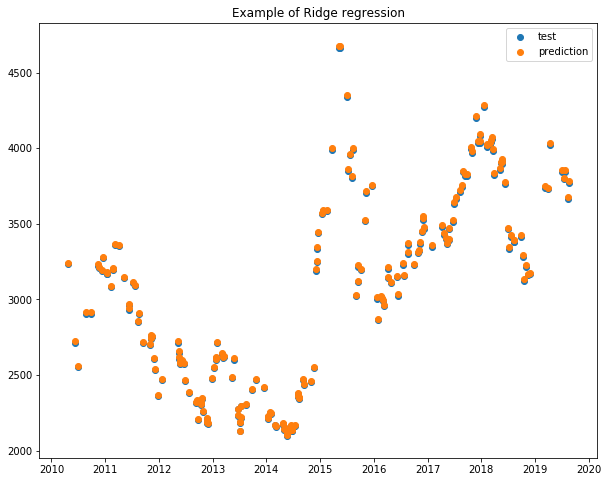

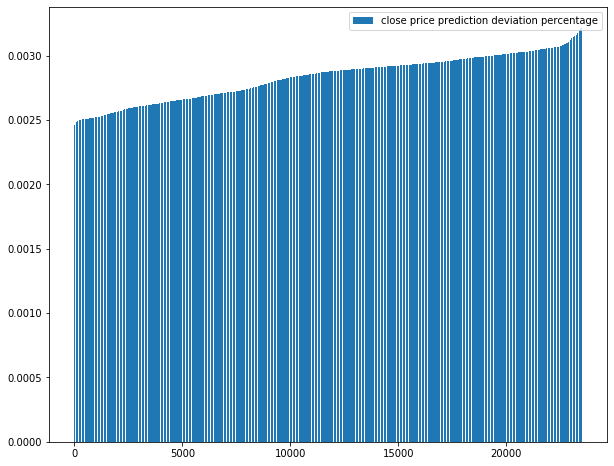

Ridge回归后拟合数据偏离度最大值:
0.003219264259425233
Ridge回归后拟合数据偏离度最小值:
0.0024543581215284386


In [53]:
alphas = np.arange(0, 0.21, 0.01)
params = {'alpha':alphas}
ridge = Ridge()
searcher = GridSearchCV(ridge, params, cv = 10)
searcher.fit(X_train_std, y_train)

best_ridge_param = searcher.best_params_
best_ridge_estimator = searcher.best_estimator_

print('最好的ridge参数为:\n{}'.format(best_ridge_param))

best_ridge_estimator.fit(X_train_std, y_train)
y_pred = best_ridge_estimator.predict(X_test_std)
y_pred = pd.Series(y_pred, index = y_test.index)
print('最好的ridge模型分数为:\n{}'.format(r2_score(y_pred, y_test)))

plt.figure(figsize = (10,8))
plt.scatter(y_test.index[-200:], y_test.iloc[-200:], label = 'test')
plt.scatter(y_pred.index[-200:], y_pred.iloc[-200:], label = 'prediction')
plt.title("Example of Ridge regression")
plt.legend(loc = 'upper right')
plt.show()

plt.figure(figsize = (10,8))
plt.bar(x = range(1, len(y_test) + 1), height = sorted((y_pred - y_test)/y_test))
plt.legend(['close price prediction deviation percentage'], loc = 'upper right')
plt.show()
print('Ridge回归后拟合数据偏离度最大值:\n{}'.format(max(np.abs((y_pred - y_test)/y_test))))
print('Ridge回归后拟合数据偏离度最小值:\n{}'.format(min(np.abs((y_pred - y_test)/y_test))))

## Lasso

最好的lasso参数为:
{'alpha': 0.0}
最好的lasso模型分数为:
0.9997931306895392


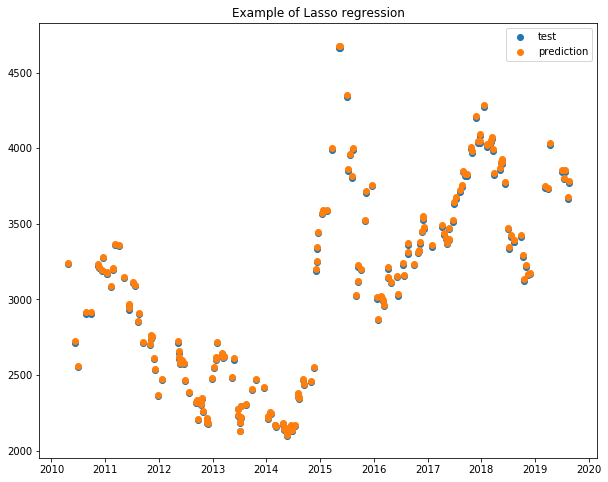

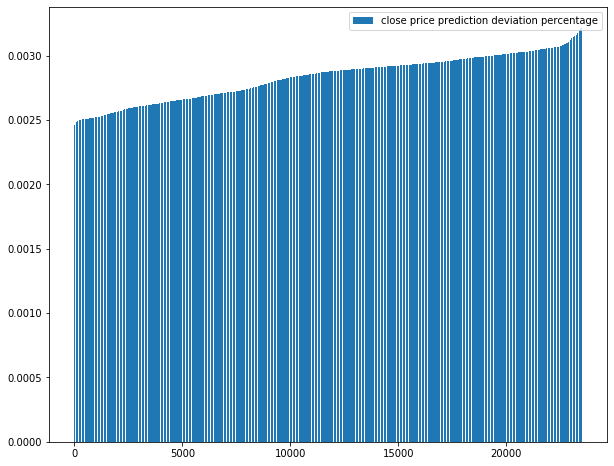

Lasso回归后拟合数据偏离度最大值:
0.003219264259425233
Lasso回归后拟合数据偏离度最小值:
0.0024543581215284386


In [54]:
lasso = Lasso()
searcher = GridSearchCV(lasso, params, cv = 10)
searcher.fit(X_train_std, y_train)

best_lasso_param = searcher.best_params_
best_lasso_estimator = searcher.best_estimator_

print('最好的lasso参数为:\n{}'.format(best_lasso_param))

best_lasso_estimator.fit(X_train_std, y_train)
y_pred = best_lasso_estimator.predict(X_test_std)
y_pred = pd.Series(y_pred, index = y_test.index)
print('最好的lasso模型分数为:\n{}'.format(r2_score(y_pred,y_test)))

plt.figure(figsize = (10,8))
plt.scatter(y_test.index[-200:], y_test.iloc[-200:], label = 'test')
plt.scatter(y_pred.index[-200:], y_pred.iloc[-200:], label = 'prediction')
plt.title("Example of Lasso regression")
plt.legend(loc = 'upper right')
plt.show()

plt.figure(figsize = (10,8))
plt.bar(x = range(1, len(y_test) + 1), height = sorted((y_pred - y_test)/y_test))
plt.legend(['close price prediction deviation percentage'], loc = 'upper right')
plt.show()
print('Lasso回归后拟合数据偏离度最大值:\n{}'.format(max(np.abs((y_pred - y_test)/y_test))))
print('Lasso回归后拟合数据偏离度最小值:\n{}'.format(min(np.abs((y_pred - y_test)/y_test))))

## Elasticnet

最好的Elasticnet参数为:
{'alpha': 0.0, 'l1_ratio': 0.0}
最好的Elasticnet模型分数为:
0.9997916020755608


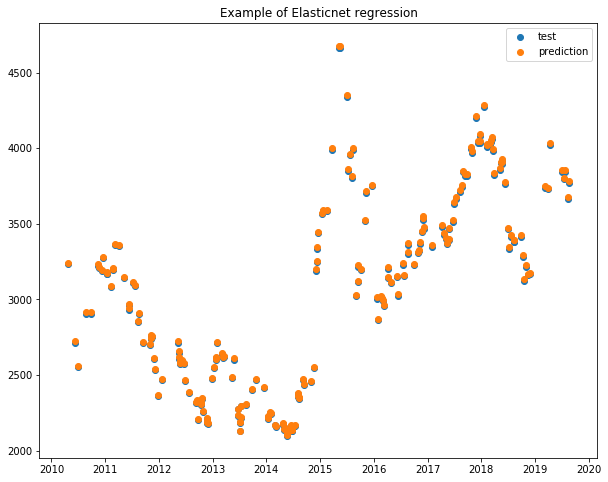

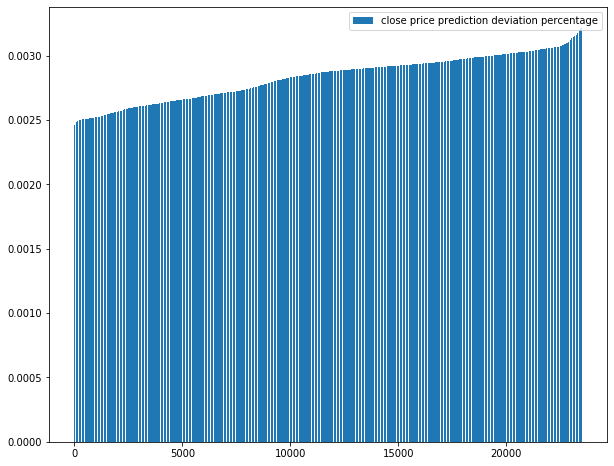

Elasticnet回归后拟合数据偏离度最大值:
0.003219264259425233
Elasticnet回归后拟合数据偏离度最小值:
0.0024543581215284386


In [55]:
l1 = alphas
elasticnet = ElasticNet()
params = {'alpha': alphas, 'l1_ratio':l1}
searcher = GridSearchCV(elasticnet, params, cv = 10)
searcher.fit(X_train_std, y_train)

best_elasticnet_params = searcher.best_params_
best_elasticnet_estimator = searcher.best_estimator_
    
print('最好的Elasticnet参数为:\n{}'.format(best_elasticnet_params))

best_elasticnet_estimator.fit(X_train_std, y_train)
y_pred = best_elasticnet_estimator.predict(X_test_std)
y_pred = pd.Series(y_pred, index = y_test.index)
print('最好的Elasticnet模型分数为:\n{}'.format(r2_score(y_test,y_pred)))

plt.figure(figsize = (10,8))
plt.scatter(y_test.index[-200:], y_test.iloc[-200:], label = 'test')
plt.scatter(y_pred.index[-200:], y_pred.iloc[-200:], label = 'prediction')
plt.title("Example of Elasticnet regression")
plt.legend(loc = 'upper right')
plt.show()

plt.figure(figsize = (10,8))
plt.bar(x = range(1, len(y_test) + 1), height = sorted((y_pred - y_test)/y_test))
plt.legend(['close price prediction deviation percentage'], loc = 'upper right')
plt.show()
print('Elasticnet回归后拟合数据偏离度最大值:\n{}'.format(max(np.abs((y_pred - y_test)/y_test))))
print('Elasticnet回归后拟合数据偏离度最小值:\n{}'.format(min(np.abs((y_pred - y_test)/y_test))))

通过以上的计算分析，我们可以发现：

- 不同的线性回归模型对于本次项目使用的数据产生的影响并不是很大，回归最终的内核数据偏离度都落在了4%左右，但不能满足1%的目标 
- 通过ElasticNet模型的拟合可以看出，最终最优的模型为普通的线性回归模型（此时alpha和l1_ratio项都为零，也即此时为普通的线性回归模型）
- 这种现象很可能是出现了过拟合的情况所导致的，因此使得越多的参数得到的模型效果越不好

线性模型结论:
线性模型由于其简单性可以体现出数据的整体趋势，但是在部分点位预测值和真实值偏离过大，因此目前不太适用于我们的交易策略的制定。

# Ensemble

In [56]:
X = df.columns.tolist()
X.remove('movement')
X = df[X]

X_train = X.loc['2017-08-22 14:50:00':'2019-07-22 14:50:00']
X_test = X.loc['2019-07-22 14:55:00':]
y_train = y['movement'].loc['2017-08-22 14:50:00':'2019-07-22 14:50:00']
y_test = y['movement'].loc['2019-07-22 14:55:00':]

## Decision Tree

最好的Decision Tree模型参数为:
{'max_depth': 4.0, 'max_features': 8, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}
最好的Decision Tree模型分数为:
0.5271739130434783
 1) macd                           0.579037
 2) bias                           0.385140
 3) atr                            0.035823
 4) ema20                          0.000000
 5) ema5                           0.000000
 6) ma20                           0.000000
 7) ma5                            0.000000
 8) open interest                  0.000000
 9) volume                         0.000000
10) close                          0.000000


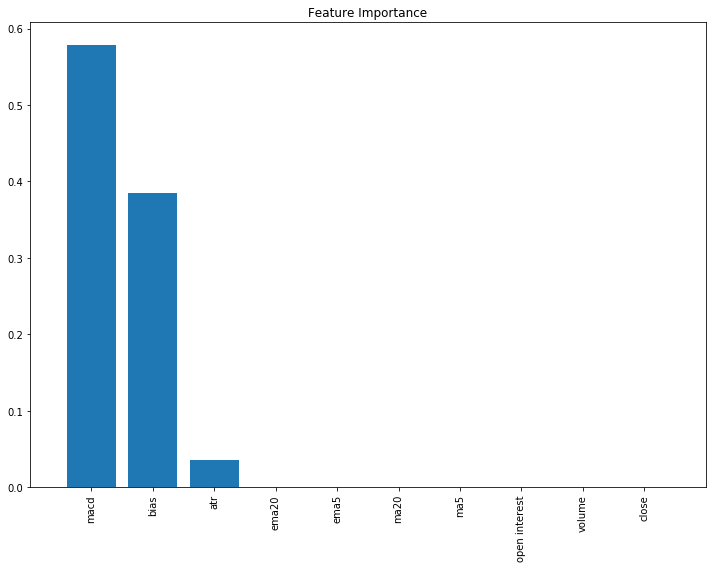

In [67]:
params = {'max_depth':np.linspace(2,10,9, endpoint = True),
          'min_samples_split':[0.1,0.5,0.9],
          'min_samples_leaf':[0.1,0.3,0.5],
          'max_features':list(range(1, X.shape[1]))}

dt = DecisionTreeClassifier(random_state = seed)
searcher = GridSearchCV(dt, params, cv = 5)
searcher.fit(X_train, y_train)

best_dt_estimator = searcher.best_estimator_
best_dt_params = searcher.best_params_
print('最好的Decision Tree模型参数为:\n{}'.format(best_dt_params))

best_dt_estimator.fit(X_train, y_train)
print('最好的Decision Tree模型分数为:\n{}'.format(best_dt_estimator.score(X_test, y_test)))

importances = best_dt_estimator.feature_importances_
indices = np.argsort(importances)[::-1]
labels = X.columns
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, labels[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(10,8))    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), height = importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

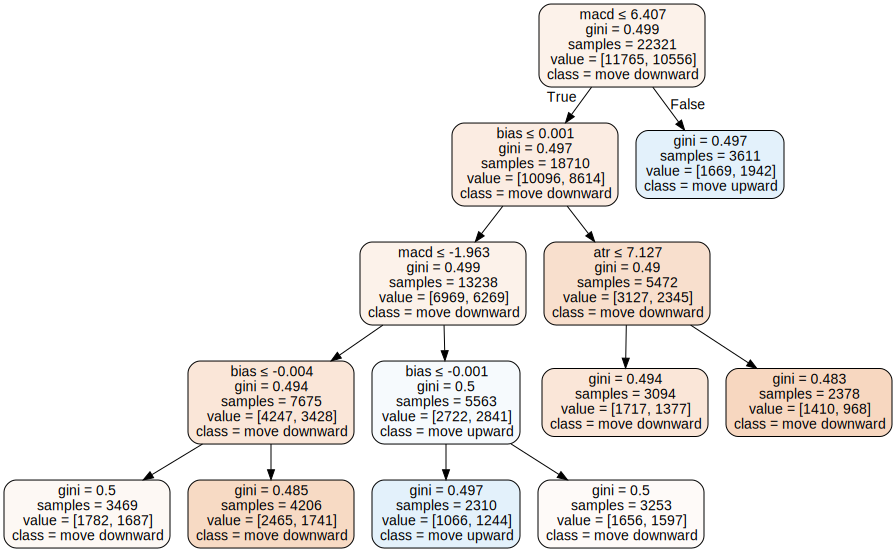

In [68]:
tree_data = tree.export_graphviz(best_dt_estimator, out_file = None,
                                 max_depth = 6,
                                 feature_names = X_test.columns,
                                 class_names = ['move downward', 'move upward'],
                                 filled=True, rounded=True,  
                                 special_characters=True)

treegraph = graphviz.Source(tree_data)

treegraph

## Random Forest

最好的Random Forest模型分数为:
{'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}
最好的Random Forest模型在测试集分数为:
0.5271739130434783
 1) macd                           0.643898
 2) bias                           0.316541
 3) close                          0.013030
 4) volume                         0.011277
 5) atr                            0.009463
 6) open interest                  0.005244
 7) ema5                           0.000548
 8) ema20                          0.000000
 9) ma20                           0.000000
10) ma5                            0.000000


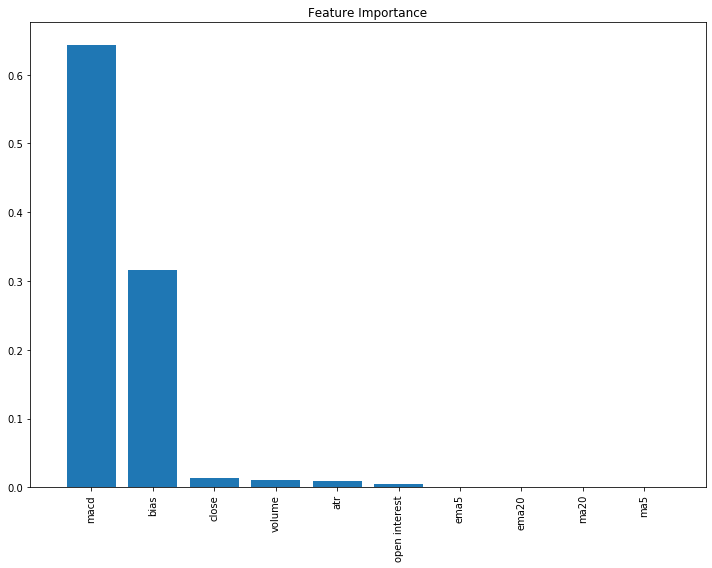

In [69]:
params = {'max_depth':[2,5,10],
          'min_samples_split':[0.1, 0.5, 0.9],
          'min_samples_leaf':[0.1, 0.3, 0.5],
          'max_features':list(range(1, X.shape[1]))}

rf = RandomForestClassifier(n_estimators = 100, random_state = seed)
searcher = GridSearchCV(rf, params, cv=5)
searcher.fit(X_train, y_train)

best_rf_estimator = searcher.best_estimator_
best_rf_params = searcher.best_params_
print('最好的Random Forest模型分数为:\n{}'.format(best_rf_params))

best_rf_estimator.fit(X_train, y_train)
print('最好的Random Forest模型在测试集分数为:\n{}'.format(best_rf_estimator.score(X_test, y_test)))

importances = best_rf_estimator.feature_importances_
indices = np.argsort(importances)[::-1]
labels = X.columns
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, labels[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(10,8))    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), height = importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()


## XGboost

最好的XGBoost模型分数为:
{'gamma': 0.2, 'reg_alpha': 100}
最好的XGBoost模型在测试集分数为:
0.5289855072463768
 1) macd                           0.344432
 2) bias                           0.204024
 3) atr                            0.167709
 4) close                          0.094733
 5) open interest                  0.090310
 6) volume                         0.073637
 7) ma5                            0.025155
 8) ema20                          0.000000
 9) ema5                           0.000000
10) ma20                           0.000000


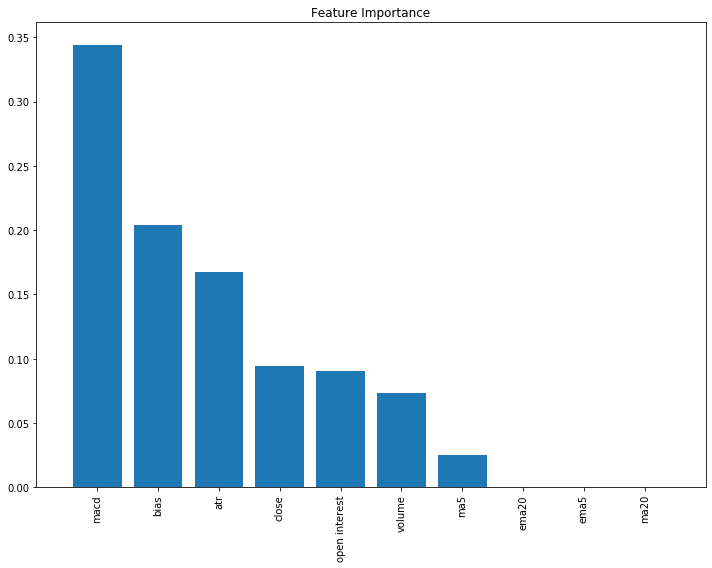

In [73]:
params = {'gamma':[i/10.0 for i in range(0,5)],
          'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
xgb = XGBClassifier(random_state = seed)
searcher = GridSearchCV(xgb, params, cv = 5)
searcher.fit(X_train, y_train)

best_xgb_estimator = searcher.best_estimator_
best_xgb_params = searcher.best_params_
print('最好的XGBoost模型分数为:\n{}'.format(best_xgb_params))

best_xgb_estimator.fit(X_train, y_train)
print('最好的XGBoost模型在测试集分数为:\n{}'.format(best_xgb_estimator.score(X_test, y_test)))

importances = best_xgb_estimator.feature_importances_
indices = np.argsort(importances)[::-1]
labels = X.columns
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, labels[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(10,8))    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), height = importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()
